# **1. Import Libraries**

In [ ]:
!pip3 install ktrain

In [ ]:
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from wordcloud import WordCloud

import ktrain
from ktrain import text

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, Dropout, Flatten

# nltk resources
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# **2. Import Dataset**

In [ ]:
#dataset https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews

dataset = pd.read_csv('tripadvisor_hotel_reviews.csv')
# dataset = pd.read_csv('/content/drive/MyDrive/tripadvisor_hotel_reviews.csv')  
print("dataset.columns: ", dataset.columns) 

dataset.columns:  Index(['Review', 'Rating'], dtype='object')


# **3. Utility Functions**

In [ ]:
# function to remove punctuation
def remove_punctuation(col):
  return col.str.replace(r'[^\w\s]+', '')

In [ ]:
# function to remove stopwords
def remove_stopwords(col):
  stop_words = stopwords.words('english')
  return col.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [ ]:
# function to lowercase text
def lowercase(col):
  return col.str.lower()

In [ ]:
# function to lemmatize words
def lemmatize_words(text):
  lemmatizer = WordNetLemmatizer()
  words = text.split()
  words = [lemmatizer.lemmatize(word,pos='v') for word in words]
  return ' '.join(words)

In [ ]:
# function to show word cloud
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        max_words=200,
        max_font_size=40, 
        scale=1,
        random_state=1).generate(" ".join(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [ ]:
# function to visualize the ratings distribution
def show_ratings_distribution(dataset):
  fig = px.histogram(dataset['Rating'],
                   labels={'value': 'Rating',
                           'count': 'Frequency',
                           'color': 'Rating'}, color=dataset['Rating'])
  fig.update_layout(bargap=0.2)
  fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
  fig.update_layout(title_text='Distribution of the Ratings',
                    title_x=0.5, title_font=dict(size=20))
  fig.show()

In [ ]:
# function to show frequent words
def show_frequent_words(dataset):
  mostUsedWords = dataset['Review'].str.split(expand=True).stack().value_counts()
  mostUsedWords_top200 = mostUsedWords[:200]

  fig = px.treemap(mostUsedWords_top200, path=[mostUsedWords_top200.index], values=0)
  fig.update_layout(title_text='The 200 Most Frequest Words',
                    title_x=0.5, title_font=dict(size=20)
                    )
  fig.update_traces(textinfo="label+value")
  fig.show()

In [ ]:
# function to vectorize text
def vectorize(col):

    # Create the vectorizer
    vectorizer = CountVectorizer()

    # Fit the vectorizer on the column
    vectorizer.fit(col)

    # Transform the column into a vector
    vectorized_column = vectorizer.transform(col)

    return vectorized_column

#**4. Data cleaning**

### **4.1.   Delete punctuation**

In [ ]:
dataset['Review'] = remove_punctuation(dataset['Review'])

### **4.2. Removing stop words**

In [ ]:
dataset['Review'] = remove_stopwords(dataset['Review'])

### **4.3. Lowercase text**

In [ ]:
dataset['Review'] = lowercase(dataset['Review'])

### **4.4 Lemmatization**

In [ ]:
dataset['Review'] = dataset['Review'].apply(lemmatize_words)

# **Exploratory Data Analysis**

In [ ]:
print("dataset.columns: ", dataset.columns) 

dataset.columns:  Index(['Review', 'Rating'], dtype='object')


In [ ]:
dataset.head()

,Review,Rating
0,nice hotel expensive park get good deal stay h...,4
1,ok nothing special charge diamond member hilto...,2
2,nice room 4 experience hotel monaco seattle go...,3
3,unique great stay wonderful time hotel monaco ...,5
4,great stay great stay go seahawk game awesome ...,5


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [ ]:
# count of ratings
show_ratings_distribution(dataset)

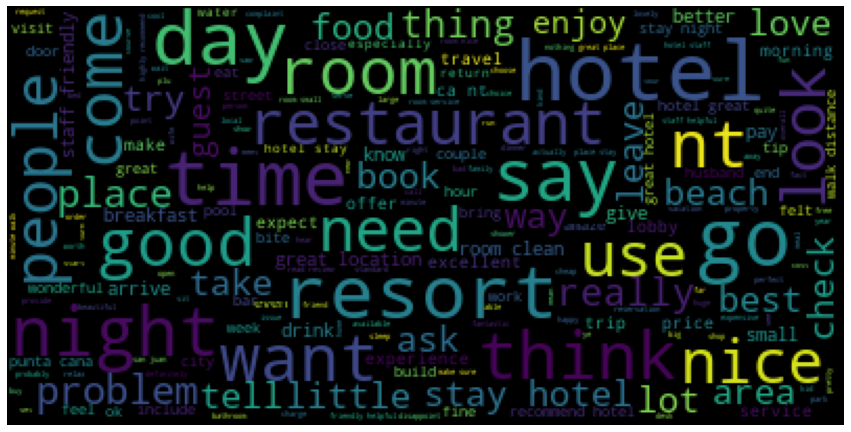

In [ ]:
show_wordcloud(dataset["Review"].values)

In [ ]:
# see null values
dataset.isnull().sum()

Review    0
Rating    0
dtype: int64

In [ ]:
show_frequent_words(dataset)

# **5. Ratings Prediction**

### **5.1. Tokenizing**



In [ ]:
# split X and y
dataset.Review = dataset.Review.str.replace('\d+', '')
X = dataset['Review'].copy()
y = dataset['Rating'].copy()

In [ ]:
def tokenize(X):

  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(X)

  X_tokenized = tokenizer.texts_to_sequences(X)

  max_length = max([len(x) for x in X])
  vocab_size = len(tokenizer.word_index)+1
  exp_sen = 1

  print("Vocabulary size: {}".format(vocab_size))
  print("max length of sentence: {}".format(max_length))
  print("\nResult\n")
  print("Original sentence:\n{}".format(X[exp_sen])) 
  print("\nAfter tokenizing :\n{}".format(X_tokenized[exp_sen]))

  X_tokenized = pad_sequences(X_tokenized, padding='post', maxlen=350)
  print("\nAfter padding :\n{}".format(X_tokenized[exp_sen]))
  
  return X_tokenized, vocab_size, max_length


In [ ]:
X_token, vocab_size, max_length = tokenize(X)

Vocabulary size: 68989
max length of sentence: 12205

Result

Original sentence:
ok nothing special charge diamond member hilton decide chain shoot th anniversary seattle start book suite pay extra website description suite bedroom bathroom standard hotel room take print reservation desk show say things like tv couch ect desk clerk tell oh mix suit description kimpton website sorry free breakfast get kid embassy suit sit room bathroom bedroom unlike kimpton call suite  day stay offer correct false advertise send kimpton prefer guest website email ask failure provide suite advertise website reservation description furnish hard copy reservation printout website desk manager duty reply solution send email trip guest survey follow email mail guess tell concern guestthe staff range indifferent helpful ask desk good breakfast spot neighborhood hood tell hotels gee best breakfast spot seattle  block away convenient hotel know exist arrive late night  pm inside run bellman busy chat cell phone

### **5.2. Encoding**

In [ ]:
encoding = {1: 0,
            2: 1,
            3: 2,
            4: 3,
            5: 4
            }

def encoding_lstm(y):
  labels = ['1', '2', '3', '4', '5']
  y.replace(encoding, inplace=True)
  return y

### **5.3 Vectorizing**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create feature vectors



def vectorize(trainData, testData):
  vectorizer = TfidfVectorizer(min_df = 5,
                              max_df = 0.8,
                              sublinear_tf = True,
                              use_idf = True)
  train_vectors = vectorizer.fit_transform(trainData)
  test_vectors = vectorizer.transform(testData)
  return train_vectors, test_vectors



### **5.4. Train/test split**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_token, y, test_size=0.33, random_state=67, stratify=y
)

### **5.5. BERT**

In [ ]:
# import ktrain
# from ktrain import text

# from collections import Counter
# %matplotlib inline

In [ ]:
#cross validation part


from sklearn.model_selection import KFold
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True)


In [ ]:
#sentiment

pos = [4, 5]
neg = [1, 2]
neu = [3]

def sentiment(rating):
  if rating in pos:
    return 2
  elif rating in neg:
    return 0
  else:
    return 1  

dataset['Sentiment'] = dataset['Rating'].apply(sentiment)
dataset.head()

,Review,Rating,Sentiment
0,nice hotel expensive park get good deal stay h...,4,2
1,ok nothing special charge diamond member hilto...,2,0
2,nice room experience hotel monaco seattle goo...,3,1
3,unique great stay wonderful time hotel monaco ...,5,2
4,great stay great stay go seahawk game awesome ...,5,2


In [ ]:

(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(dataset, 
                                                                    'Review',
                                                                    label_columns=['Sentiment'],
                                                                    preprocess_mode='bert')

model = text.text_classifier(name='bert',
                             train_data=(X_train, y_train),
                             preproc=preproc)


learner = ktrain.get_learner(model=model,
                             train_data=(X_train, y_train),
                             val_data=(X_test, y_test),
                             batch_size=6)


learner.fit_onecycle(lr=2e-5,
                     epochs=1)


['Sentiment_0', 'Sentiment_1', 'Sentiment_2']
       Sentiment_0  Sentiment_1  Sentiment_2
8100           1.0          0.0          0.0
15025          0.0          0.0          1.0
4475           0.0          0.0          1.0
13893          0.0          0.0          1.0
5890           0.0          0.0          1.0
['Sentiment_0', 'Sentiment_1', 'Sentiment_2']
       Sentiment_0  Sentiment_1  Sentiment_2
2147           0.0          0.0          1.0
3909           0.0          0.0          1.0
18212          0.0          0.0          1.0
6696           0.0          0.0          1.0
12171          0.0          0.0          1.0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 400
done.


begin training using onecycle policy with max lr of 2e-05...
 288/3074 [=>............................] - ETA: 19:06:02 - loss: 0.6397 - accuracy: 0.7697

In [ ]:
################################################################

#expirimental part
from sklearn.model_selection import cross_validate

# Define the scoring metric(s) you want to use
scoring = ['accuracy', 'f1_macro']

# Perform cross validation
scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=5, return_train_score=True)

# Print the results
print("Cross validation scores: ", scores)

In [ ]:
import ktrain
from sklearn.model_selection import KFold

n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True)

for fold, (train_index, val_index) in enumerate(kf.split(dataset)):
    X_train, X_val = dataset.iloc[train_index], dataset.iloc[val_index]
    (X_train, y_train), (X_test, y_val), preproc = text.texts_from_df(X_train, 
                                                                    'Review',
                                                                    label_columns=['Sentiment'],
                                                                    preprocess_mode='bert') 
    model = text.text_classifier(name='bert',
                             train_data=(X_train, y_train),
                             preproc=preproc)
    learner = ktrain.get_learner(model=model,
                             train_data=(X_train, y_train),
                             val_data=(X_val, y_val),
                             batch_size=6)
    learner.fit_onecycle(lr=2e-5, epochs=1)
    #evaluate the model
    val_acc = learner.validate(val_data=(X_val, y_val))
    print("Fold: {} | Validation Acc: {:.4f}".format(fold+1, val_acc[1]))



['Sentiment_0', 'Sentiment_1', 'Sentiment_2']
       Sentiment_0  Sentiment_1  Sentiment_2
19028          0.0          0.0          1.0
1483           1.0          0.0          0.0
10045          0.0          0.0          1.0
676            1.0          0.0          0.0
2472           1.0          0.0          0.0
['Sentiment_0', 'Sentiment_1', 'Sentiment_2']
       Sentiment_0  Sentiment_1  Sentiment_2
5318           0.0          0.0          1.0
10969          0.0          0.0          1.0
8568           0.0          0.0          1.0
14377          0.0          0.0          1.0
8685           0.0          0.0          1.0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 400
done.


ValueError: ignored

### **5.6 Naive Bayes**


In [ ]:

# Convert the training data into numerical feature vectors
# X_train = vectorizer.fit_transform(X_train.ravel)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=67, stratify=y
)
# Create the multinomial naive Bayes classifier and train it on the training data
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Use the trained classifier to make predictions on the test data
y_pred = clf.predict(X_test)

# Print the predictions
print(y_pred)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

[5 3 3 ... 1 5 5]
0.31731480112376165


### **5.7 Simple Feed Forward Network**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['Review'], dataset['Rating'], test_size=0.2)

In [ ]:
tfid = TfidfVectorizer()
train_tfid_matrix = tfid.fit_transform(X_train)
test_tfid_matrix = tfid.transform(X_test)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import regularizers

In [ ]:
#BUILDING MODEL WITH TENSORFLOW
from sklearn import preprocessing

tokenizer = Tokenizer(num_words=50000, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)
# print(tokenizer.word_index)
total_word = len(tokenizer.word_index)
print('Total distinct words: {}'.format(total_word))

train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq)

test_seq = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_seq)

# One hot encoding the label
lb = LabelBinarizer()
train_labels = lb.fit_transform(y_train)
test_labels = lb.transform(y_test)

Total distinct words: 59683


In [ ]:
model = tf.keras.models.Sequential([tf.keras.layers.Embedding(total_word, 8),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(8, kernel_regularizer=l2(0.001),
                                                          bias_regularizer=L2(0.001), activation='relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(3, activation='softmax')])

model.summary()

NameError: ignored

In [ ]:
from tensorflow.keras import regularizers

model = tf.keras.models.Sequential([tf.keras.layers.Embedding(total_word, 8),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(8, kernel_regularizer=regularizers.l2(0.001),
                                                          bias_regularizer=regularizers.L2(0.001), activation='relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(5, activation='softmax')])


In [ ]:
print("train_padded shape:", train_padded.shape)
print("train_labels shape:", train_labels.shape)


train_padded shape: (16392, 1725)
train_labels shape: (16392, 5)


In [ ]:
train_padded

array([[    0,     0,     0, ...,   222,   416,   474],
       [    0,     0,     0, ...,   264,   137,    52],
       [    0,     0,     0, ...,   585,   105,    64],
       ...,
       [    0,     0,     0, ...,    10,   181,    65],
       [    0,     0,     0, ...,   198,     6,   111],
       [    0,     0,     0, ..., 20963,    85,  2815]], dtype=int32)

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_padded, train_labels, epochs=25, validation_data=(test_padded, test_labels))

Epoch 1/25
513/513 [==============================] - 57s 96ms/step - loss: 1.5481 - accuracy: 0.3839 - val_loss: 1.4583 - val_accuracy: 0.4455
Epoch 2/25
513/513 [==============================] - 47s 92ms/step - loss: 1.4745 - accuracy: 0.4069 - val_loss: 1.4110 - val_accuracy: 0.4455
Epoch 3/25
513/513 [==============================] - 49s 96ms/step - loss: 1.4123 - accuracy: 0.4143 - val_loss: 1.3241 - val_accuracy: 0.4455
Epoch 4/25
513/513 [==============================] - 49s 95ms/step - loss: 1.3201 - accuracy: 0.4265 - val_loss: 1.2134 - val_accuracy: 0.4501
Epoch 5/25
513/513 [==============================] - 49s 95ms/step - loss: 1.2777 - accuracy: 0.4491 - val_loss: 1.1968 - val_accuracy: 0.4496
Epoch 6/25
513/513 [==============================] - 49s 95ms/step - loss: 1.2293 - accuracy: 0.4591 - val_loss: 1.1609 - val_accuracy: 0.4782
Epoch 7/25
513/513 [==============================] - 48s 94ms/step - loss: 1.1976 - accuracy: 0.4782 - val_loss: 1.1448 - val_accuracy:

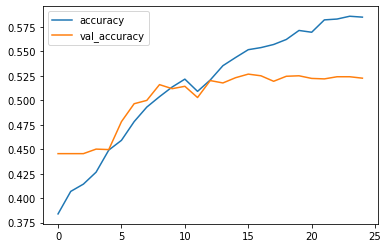

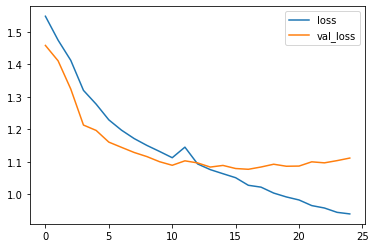

In [ ]:
metrics = pd.DataFrame(model.history.history)
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['loss', 'val_loss']].plot()

In [ ]:
pred2 = model.predict(test_padded)

129/129 [==============================] - 6s 43ms/step


In [ ]:
true_labels = np.argmax(test_labels, axis=-1)
pred_labels = np.argmax(pred2, axis=-1)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(true_labels, pred_labels))
print(classification_report(true_labels, pred_labels))

[[   0    0    0  299    2]
 [   0    0    0  340    9]
 [   0    0    0  431   39]
 [   0    0    0  680  473]
 [   0    0    0  364 1462]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       301
           1       0.00      0.00      0.00       349
           2       0.00      0.00      0.00       470
           3       0.32      0.59      0.42      1153
           4       0.74      0.80      0.77      1826

    accuracy                           0.52      4099
   macro avg       0.21      0.28      0.24      4099
weighted avg       0.42      0.52      0.46      4099



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
model.save('dl_model.h5')

### **5.8 Convolutional Neural Network**

In [ ]:
# extract the review text and rating
reviews = dataset["Review"].values
ratings = dataset["Rating"].values

# create a tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(reviews)

# convert the reviews to sequences
review_sequences = tokenizer.texts_to_sequences(reviews)

# pad the sequences to the same length
max_length = max([len(seq) for seq in review_sequences])
review_sequences = pad_sequences(review_sequences, maxlen=max_length)

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(review_sequences, ratings, test_size=0.2, random_state=67)

# build the CNN model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index), 128, input_length=max_length))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

# compile the model
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

# train the model
model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test))



Epoch 1/3
513/513 [==============================] - 11s 20ms/step - loss: 0.0000e+00 - accuracy: 0.0697 - val_loss: 0.0000e+00 - val_accuracy: 0.0678
Epoch 2/3
513/513 [==============================] - 10s 20ms/step - loss: 0.0000e+00 - accuracy: 0.0697 - val_loss: 0.0000e+00 - val_accuracy: 0.0678
Epoch 3/3
513/513 [==============================] - 10s 20ms/step - loss: 0.0000e+00 - accuracy: 0.0697 - val_loss: 0.0000e+00 - val_accuracy: 0.0678


# **Result Evaluation**